In [1]:
# Import Libraries and Dependencies
from vilib.matrix_games.base import mg_problem
from vilib.matrix_games.generate import*
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import numpy.linalg as LA

In [2]:
dimN = 3
dimM = 3
q0 = np.ones(dimN + dimM)
proximal_name = "simplex"

#A = create_A("rand_sparse", (dimN,dimM))
prob = mg_problem("rand", proximal_name, (dimN, dimM), "plusuniform")
#filepaths = ["test.h5", "testT.h5", False]
#prob = mg_problem("load_harddisk", proximal_name, (dimN, dimM), filepaths)
F_mg, J_mg, prox_g_mg = prob.get_parameters()
prob.get_all()

(array([[-9.12325954,  4.94352879, -3.55179341],
        [ 0.90652262, -3.23800687,  6.28126637],
        [ 8.18824634, -7.04355413, -4.51569194]]),
 <function vilib.matrix_games.base.intern_Fx.<locals>.operator(q)>,
 array([[ 0.        ,  0.        ,  0.        , -9.12325954,  0.90652262,
          8.18824634],
        [ 0.        ,  0.        ,  0.        ,  4.94352879, -3.23800687,
         -7.04355413],
        [ 0.        ,  0.        ,  0.        , -3.55179341,  6.28126637,
         -4.51569194],
        [ 9.12325954, -4.94352879,  3.55179341,  0.        ,  0.        ,
          0.        ],
        [-0.90652262,  3.23800687, -6.28126637,  0.        ,  0.        ,
          0.        ],
        [-8.18824634,  7.04355413,  4.51569194,  0.        ,  0.        ,
          0.        ]]),
 <function vilib.matrix_games.base.intern_J.<locals>.J(q)>,
 <function vilib.matrix_games.base.intern_proxg.<locals>.prox_g(q, eps)>)

In [3]:
print(prox_g_mg)
print(prob)
print(F_mg(q0))

<function intern_proxg.<locals>.prox_g at 0x000001EF4CD754C8>
Matrix A: [[-9.12325954  4.94352879 -3.55179341]
 [ 0.90652262 -3.23800687  6.28126637]
 [ 8.18824634 -7.04355413 -4.51569194]]
 Matrix F: [-0.02849058 -5.3380322  -1.78621898  7.73152416 -3.94978212  3.37099972]
 Proximal Operator: [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
 Simplex?: True
 J Operator: 9.287814317811048

[-0.02849058 -5.3380322  -1.78621898  7.73152416 -3.94978212  3.37099972]


Adaptive Graal Implemntation

In [10]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)
        if output:
            #print("F: ", Fx1, "\n")
            print("x: ", x1, "\n")
            print("sum: ", sum(x1), "\n")
            print("x>=0: ", np.any((x1 >= 0)))
            #print("prox: ", prox_g(x_ - la * Fx, la), "\n")

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        #if output:
            #print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

Solving the VI

In [11]:
N = 10000

# starting point
q0 = prox_g_mg(np.ones(dimN + dimM),1)

In [12]:
show_out = False
ans1 = adaptive_graal(J_mg, F_mg, prox_g_mg, q0, numb_iter=N, phi=1.5, output=show_out)

CPU time for aGRAAL: 1.4421546000000003


In [13]:
if show_out:
    print("J(x): " , ans1[0][-1])
    print("x: " ,ans1[1])
    print("diff: ", ans1[4])

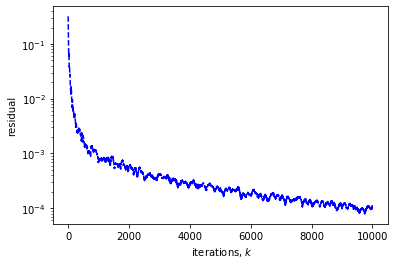

In [14]:
plt.plot(ans1[0], '--b')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()

Linesearch

In [ ]:
def tseng_fbf_linesearch(J, F, prox_g, x0, delta=2, numb_iter=100):
    """
    Tseng's forward-backward-forward algorithm with linesearch for
    monotone inclusion $0 \in F + \partial g.
    Notice that FBF algorithm in this form works only for Nash
    problem, as every time we project x onto the nonnegative orthant
    to make it feasible.
    
    Input 
    -----
    J : function that computes residual in every iteration.
        Takes x as input.
    F : main operator.
        Takes x as input.
    prox_g: proximal operator.
        Takes two parameters x and a scalar as input.
    x0: Strating point.
        np.array, must be consistent with J, F and prox_g.
    delta: a positive number.
        Allows stepsize to increase from iteration to iteration. 
    numb_iter: number of iteration to run rhe algorithm.
    Return
    ------
    iterates: a list of 
        values (another list that collects all values J(x)), 
        x : last iterate.
        la : a positive number, last stepsize.
        n_F: number of F evaluated in total.
        n_prox: number of proximal maps evaluated in total.
    """
    begin = perf_counter()
    beta = 0.7
    theta = 0.99

    x1 = x0 + np.random.randn(x0.shape[0]) * 1e-9
    Fx = F(x0)

    la0 = LA.norm(F(x1)-Fx)/ LA.norm(x1-x0)
    iterates = [[J(x0)], x0, la0, 1, 0]

    def iter_T(values, x, la, n_F, n_prox):
        Fx = F(x)
        la *= delta
        for j in range(100):
            z = prox_g(x - la * Fx, la)
            Fz = F(z)
            if la * LA.norm(Fz - Fx) <= theta * LA.norm(z - x):
                break
            else:
                la *= beta
        #x1 = z - la * (Fz - Fx)
        x1 = np.fmax(z - la * (Fz - Fx), 0)
        # print j, la
        values.append(J(z))
        # n_f += j+1
        n_F += j + 2
        n_prox += j + 1
        ans = [values, x1, la,  n_F, n_prox]
        return ans

    for i in range(numb_iter):
        iterates = iter_T(*iterates)

    end = perf_counter()
    #print("---- FBF ----")
    #print("Number of iterations:", numb_iter)
    #print("Number of gradients, n_grad:", iterates[-2])
    #print("Number of prox_g:", iterates[-1])
    print("CPU time for FBF:", end - begin)
    return iterates

In [ ]:
N = 1000
show_out = False
q0 = prox_g_mg(np.ones(dimN + dimM),1)
ans1 = tseng_fbf_linesearch(J_mg, F_mg, prox_g_mg, q0, 2, N)

In [ ]:
plt.plot(ans1[0], '--b')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()

ExtraGradient Method

In [ ]:
def extra_gradient_method(J, F, prox_g, x1, numb_iter,output):
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = 2e-2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    s = 0
    scount = 0

    for i in range(numb_iter):
        y = prox_g(x_ - la * Fx, la)
        Fy = F(y)
        x1 = prox_g(x_ - la * Fy, la)
        Fx1 = F(x1)
        if output:
            #print("F: ", Fx1, "\n")
            print("x: ", x1, "\n")
            print("sum: ", sum(x1), "\n")
            print("x>=0: ", np.any((x1 >= 0)))
            print("prox: ", prox_g(x_ - la * Fx, la), "\n")
        
        x_, Fx = x1, Fx1#, la1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

In [ ]:
N = 1000

# starting point
q0 = prox_g_mg(np.ones(dimN + dimM),1)
show_out = False
ans1 = extra_gradient_method(J_mg, F_mg, prox_g_mg, q0, N, show_out)

In [ ]:
plt.plot(ans1[0], '--b')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()